In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import *
from src.datasets import *
from src.residual import get_volume_residual

import jax
import mrcfile
from jax.scipy.special import gammaln
from external.pyem.pyem import star
import pandas as pd


plt.rcParams["figure.figsize"]=6,6

In [3]:
out_dir = "../simulated_dataset/"

In [4]:
# The first volume

refine3dfile1 = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/Refine3D/job019/run_class001.mrc"
vol1_r = mrcfile.open(refine3dfile1).data

# And the parameters from the star file
data_dir1 = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file1 = "/Extract/job018/particles.star"


params1, _ = load_data(data_dir1, star_file1, load_imgs = False, fourier = False)
ctf_params1 = params1["ctf_params"]
pixel_size1 = params1["pixel_size"]
angles1 = params1["angles"]
shifts1 = params1["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  1.0466127395629883


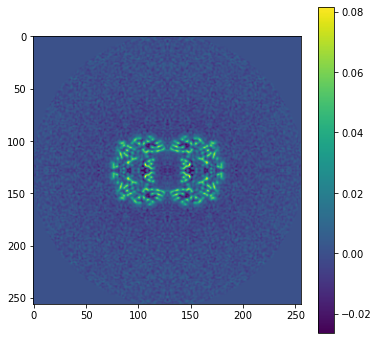

In [5]:
plt.imshow(vol1_r[128]); plt.colorbar()

In [6]:
# The second volume

refine3dfile2 = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/run_class001.mrc"
vol2_r = mrcfile.open(refine3dfile2).data

data_dir2 = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/"
star_file2 = "/run_it000_data.star"

params2, _ = load_data(data_dir2, star_file2, load_imgs = False, fourier = False)
ctf_params2 = params2["ctf_params"]
pixel_size2 = params2["pixel_size"]
angles2 = params2["angles"]
shifts2 = params2["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  105519
load_data: data loaded, time:  25.32058024406433


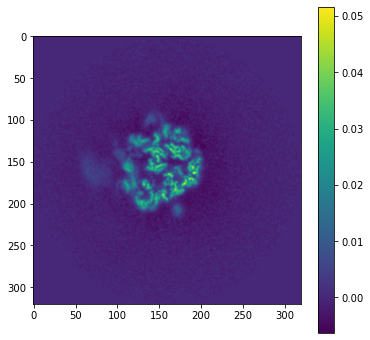

In [7]:
plt.imshow(vol2_r[128]); plt.colorbar()

In [8]:
print(vol1_r.shape)
print(vol2_r.shape)

print(pixel_size1[0])
print(pixel_size2[0])

(256, 256, 256)
(320, 320, 320)
1.244531
1.31


In [9]:
pixel_size1 = pixel_size1[0]
pixel_size2 = pixel_size2[0]

In [10]:
nx = 128

vol1, grid1, _ = volume_fourier(vol1_r, pixel_size1)
vol1, grid1 = crop_fourier_volume(vol1, grid1, nx)

vol2, grid2, _ = volume_fourier(vol2_r, pixel_size1)
vol2, grid2= crop_fourier_volume(vol2, grid2, nx)

vol1_cr = np.real(np.fft.fftshift(np.fft.ifftn(vol1)))
vol2_cr = np.real(np.fft.fftshift(np.fft.ifftn(vol2)))

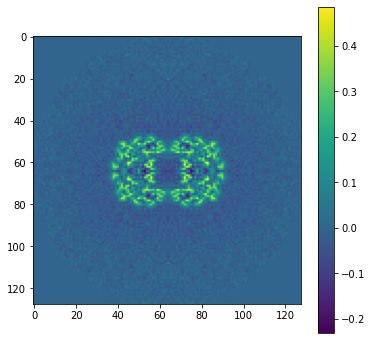

In [11]:
plt.imshow(vol1_cr[64]); plt.colorbar()

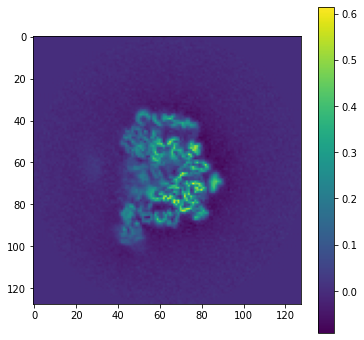

In [12]:
plt.imshow(vol2_cr[64]); plt.colorbar()

In [13]:
with mrcfile.new(f"{out_dir}/vol1.mrc", overwrite=True) as mrc:
    mrc.set_data(vol1_cr.astype(np.float32))
with mrcfile.new(f"{out_dir}/vol2.mrc", overwrite=True) as mrc:
    mrc.set_data(vol2_cr.astype(np.float32))

In [14]:
ctf_params_common = ctf_params1[0]
pixel_size_common = pixel_size1
grid_common = grid1

In [15]:
N1 = 10000
N2 = 10000

angles1 = generate_uniform_orientations(N1)
angles2 = generate_uniform_orientations(N2)

In [16]:
mask = np.ones(vol1.shape)
slice_func, slice_func_array, _ = get_slice_funcs(project, grid_common, mask)

In [17]:
def write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs_f, angles, shifts, ctf_params):
                    
    # First take IFFT
    imgs = np.array([np.real(np.fft.fftshift(np.fft.ifft2(img_f.reshape([nx,nx])))) for img_f in imgs_f])
    
    # And write to mrcs file
    with mrcfile.new(f"{out_dir}/{mrcs_dir}/{imgs_filename}.mrcs", overwrite=True) as mrc:
        mrc.set_data(imgs.astype(np.float32))
    
    # Create star file

    # See, for example, this one:
    df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
    #df
    #df.keys()

    newdf = pd.DataFrame()
    newdf["index"] = np.arange(N)

    newdf[star.Relion.ANGLEPSI] = np.rad2deg(angles[:,0])
    newdf[star.Relion.ANGLETILT] = np.rad2deg(angles[:,1])
    newdf[star.Relion.ANGLEROT] = np.rad2deg(angles[:,2])

    newdf[star.Relion.ORIGINX] = 0
    newdf[star.Relion.ORIGINY] = 0
    newdf[star.Relion.ORIGINXANGST] = 0
    newdf[star.Relion.ORIGINYANGST] = 0

    newdf[star.Relion.DEFOCUSU] = ctf_params[:,0] 
    newdf[star.Relion.DEFOCUSV] = ctf_params[:,1]
    newdf[star.Relion.DEFOCUSANGLE] = ctf_params[:,2]
    newdf[star.Relion.PHASESHIFT] = ctf_params[:,3]
    newdf[star.Relion.VOLTAGE] = ctf_params[:,4]
    newdf[star.Relion.AC] = ctf_params[:,5]
    newdf[star.Relion.CS] = ctf_params[:,6]

    newdf[star.Relion.IMAGESIZE] = vol.shape[0]
    newdf[star.Relion.IMAGEPIXELSIZE] = pixel_size_common 

    newdf[star.Relion.VOLTAGE] = df[star.Relion.VOLTAGE][0] 
    newdf[star.Relion.OPTICSGROUP] = 1
    newdf[star.Relion.OPTICSGROUPNAME] = df[star.Relion.OPTICSGROUPNAME][0]
    newdf[star.Relion.CTFSCALEFACTOR] = df[star.Relion.CTFSCALEFACTOR][0]

    #newdf[star.UCSF.IMAGE_ORIGINAL_PATH] = f"{imgs_filename}.mrcs"
    newdf[star.Relion.IMAGE_NAME] = [f"{i}@{imgs_filename}.mrcs" for i in np.arange(N)]
    #newdf
    
    star.write_star(f"{out_dir}/{mrcs_dir}/{imgs_filename}", newdf)
    
    return imgs, imgs_f, newdf

### 1. Relion, noise-free

In [18]:
mrcs_dir = "relion_clean/"
imgs_filename = "particles"

vol = vol1
angles = angles1
N = angles.shape[0]
shifts = np.zeros([N,2])
ctf_params = jnp.tile(ctf_params_common, (N,1))

In [19]:
# Take projections in Fourier
imgs_f = slice_func_array(vol, angles, shifts, ctf_params)

In [20]:
imgs, imgs_f, df = write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs_f, angles, shifts, ctf_params)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [21]:
#df

In [22]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[14].reshape([128,128])))); plt.colorbar()

In [23]:
#plt.imshow(imgs[53]); plt.colorbar()

### 2. Cryodrgn, noise-free

In [24]:
mrcs_dir = "cryodrgn_clean/"
imgs_filename = "particles"

vol = vol2
angles = angles2
N = angles.shape[0]
shifts = np.zeros([N,2])
ctf_params = jnp.tile(ctf_params_common, (N,1))

In [25]:
# Take projections in Fourier
imgs_f = slice_func_array(vol, angles, shifts, ctf_params)

In [26]:
imgs, imgs_f, df = write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs_f, angles, shifts, ctf_params)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


### 3. Relion + Cryodrgn, noise-free

In [27]:
mrcs_dir = "mixed_clean/"
imgs_filename = "particles"

shifts1 = np.zeros([N1,2])
shifts2 = shifts1

ctf_params1 = np.tile(ctf_params_common, (N1,1))
ctf_params2 = ctf_params1

In [28]:
# Take projections in Fourier
imgs_f1 = slice_func_array(vol1, angles1, shifts1, ctf_params1)
imgs_f2 = slice_func_array(vol2, angles2, shifts2, ctf_params2)

In [29]:
angles = np.concatenate([angles1, angles2], axis=0)
imgs_f = np.concatenate([imgs_f1, imgs_f2], axis=0)  
shifts = np.concatenate([shifts1, shifts2], axis=0)
ctf_params = np.concatenate([ctf_params1, ctf_params2], axis=0)

N = angles.shape[0]

z = np.concatenate([np.zeros([int(N/2),1]), np.ones([int(N/2),1])], axis=0)

In [30]:
idx = np.random.permutation(N)

imgs_f = imgs_f[idx]
angles = angles[idx]
z = z[idx]

In [31]:
imgs, imgs_f, df = write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs_f, angles, shifts, ctf_params)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


In [32]:
# Also print the z to file
file = open(f"{out_dir}/{mrcs_dir}/z.pkl", 'wb')
pickle.dump(z, file)
file.close()